# Loading the video

Mount Google drive through using drive.mount('/content/drive') Ceate a shortcut to the class Google Drive home directory to the location where the data is: Open the class Google Doc Folder https://drive.google.com/drive/folders/17dFdrIbTp8RjivAuOiLNyb8pTqZ8QqgL ("SCIP_IMAGE_PYTHON_2022"), Right click on "SCIP_DATA",click "Add shortcut to drive".

Run the code below to mount the class code data. You should be able to find image and video files in the folder (on the left) under drive/MyDrive/SCIP_DATA.

In [ ]:
#import glob
from google.colab import drive
import matplotlib.pyplot as plt
from IPython import display
from time import sleep
import cv2
#%matplotlib inline 
from google.colab.patches import cv2_imshow

drive.mount('/content/drive')

Mounted at /content/drive


# Answer 1: Reading a specified frame from the video

Here we select a specifid frame to load and view using the command "ap.set(cv2.CAP_PROP_POS_FRAMES, frameNumber)". We put it in a loop to select every 30th frame from 0 to 300. Since the video is approximately 30 frames per second, the program displays one frame ever second of video recording.

In [ ]:
vid='/content/drive/MyDrive/SCIP_DATA/Video/planktonWhite_1920_1080.mp4'
cap = cv2.VideoCapture(vid)
xRez=480; yRez=270; # reduce image so display is faster
print('Cap opened?',cap.isOpened())
for frameNumber in range(0,300,30):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frameNumber) # move frame pointer to frameNumber
    # get image
    ret, frameIM = cap.read()                     # load frame
    frameIM = cv2.resize(frameIM, (xRez, yRez))
    cv2_imshow(frameIM)
    print('frame=',frameNumber)
    sleep(.3)
    display.display(plt.gcf())
    display.clear_output(wait=True)
cap.release()


<Figure size 432x288 with 0 Axes>

# Answer 2: Cropping a specific window from the video frame

Here we select a small section ("cropped window") from the full resolution video frame.

In [ ]:
frameCount=0
framesToDisplay=30
x0=1000; y0=200;
w=400; h=300;
cap.set(cv2.CAP_PROP_POS_FRAMES, frameNumber) # move frame pointer to frameNumber
cap = cv2.VideoCapture(vid)
while(cap.isOpened() and frameCount<framesToDisplay):
    # get image
    ret, frameIM = cap.read()

    # convert to gray image
    grayIM = cv2.cvtColor(frameIM, cv2.COLOR_BGR2GRAY)    # convert color to grayscale image
    
    # crop image 
    grayCropIM=grayIM[y0:y0+h, x0:x0+w]
    
    # display image
    cv2_imshow(grayCropIM)
    sleep(.3)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    frameCount+=1
cap.release()

<Figure size 432x288 with 0 Axes>

# Answer 3: Ramping the threshold on an individual frame

One way to determine what a good threshold value is uses a loop to vary the threshold form low to high and visually inspect the output to determine the best threshold. So we load a frame of the video and in a loop keep on applying a threshould that grows in value.



In [ ]:
thresh=80 # used to determine if a pixel is assigned 0 or 255
frameCount=0
CROP_SIZE=4 # number of pixels to remove on each side of image
cap = cv2.VideoCapture(vid)
# get image
ret, frameIM = cap.read()
grayIM = cv2.cvtColor(frameIM, cv2.COLOR_BGR2GRAY)    # convert color to grayscale image
for thresh in range(1,200,2):
    ret,binaryIM = cv2.threshold(grayIM,thresh,255,cv2.THRESH_BINARY_INV) # invert threshold output so dark objects show as white
    frameIM = cv2.resize(frameIM, (xRez, yRez))
    
    cv2_imshow(binaryIM)
    print('thresh=',thresh)
    sleep(.5)
    display.display(plt.gcf())
    display.clear_output(wait=True)
cap.release()

<Figure size 432x288 with 0 Axes>

# Answer 4 Detecting the largest object in the frame

To detect the largest object in each frame, we first make a list of the area of each object, find the greatest area, then use the contour points of the object with the largest area to mark it's location. 

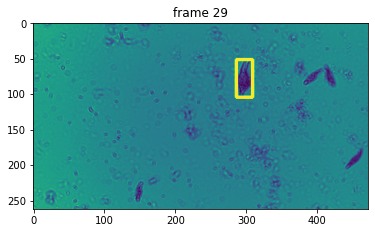

In [ ]:
thresh=80 # used to determine if a pixel is assigned 0 or 255
frameCount=0
CROP_SIZE=4 # number of pixels to remove on each side of image
thick=3   # thickness of rectangle lines around detected objects
cap = cv2.VideoCapture(vid)
while(cap.isOpened() and frameCount<framesToDisplay):
    # get image
    ret, frameIM = cap.read()
    if not ret: # check to make sure there was a frame to read
      print('Can not find video or we are all done')
      break
    frameIM = cv2.resize(frameIM, (xRez, yRez))
    grayIM = cv2.cvtColor(frameIM, cv2.COLOR_BGR2GRAY)    # convert color to grayscale image
    grayIM=grayIM[CROP_SIZE:yRez-CROP_SIZE,CROP_SIZE:xRez-CROP_SIZE]
    ret,binaryIM = cv2.threshold(grayIM,thresh,255,cv2.THRESH_BINARY_INV) # threshold image to make pixels 0 or 255
    
    # get the area of all the objects in binaryIM
    areaList=[] # we will fill this with the area of all the objects
    contourList, hierarchy = cv2.findContours(binaryIM, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # all countour points, uses more memory
    objectCount=0 # counts number of objects detected
    for objContour in contourList:
        area = cv2.contourArea(objContour)
        areaList.append(area)
        objectCount+=1

    # get the index (location in list) of the maximum area in the list of areas
    maxArea=max(areaList)             # find the max area in the list
    maxIndex=areaList.index(maxArea)  # find the location of the max area in the list. we will use this index to point to the contour points for the object
    print('maxArea',maxArea,'maxIndex',maxIndex)

    # get the contour points that correspond to the object with the largest area
    maxCountourPoints=contourList[maxIndex]

    # put a rectangle around the object with the greatest area using it's contour points (maxCountourPoints)
    PO = cv2.boundingRect(maxCountourPoints)
    x0=PO[0]; y0=PO[1]; w=PO[2]; h=PO[3]
    cv2.rectangle(grayIM, (x0,y0), (x0+w,y0+h),255, thick) # place rectangle around each object, BGR
    plt.imshow(grayIM)
    plt.title('frame ' + str(frameCount))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    frameCount+=1
cap.release()

# Answer 5 Color code objects that are too small and too big

Let's put a yellow rectangle around objects that are too small, a red rectangle around objects that are too big, and a green rectangle around objects that are neither too small or large. Since we want to represent color, we will use the original color frame (frameIM) to draw the colored rectangles on.

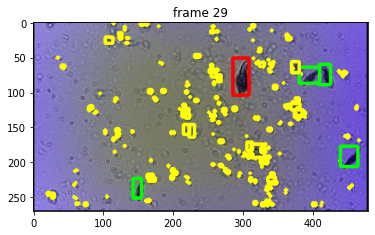

In [ ]:
thresh=80 # used to determine if a pixel is assigned 0 or 255
frameCount=0
minArea=100; maxArea=500; # in pixels. I reduced the maxArea so some objects will be larger 
CROP_SIZE=4 # number of pixels to remove on each side of image
thick=3   # thickness of rectangle lines around detected objects
cap = cv2.VideoCapture(vid)
while(cap.isOpened() and frameCount<framesToDisplay):
    # get image
    ret, frameIM = cap.read()
    if not ret: # check to make sure there was a frame to read
      print('Can not find video or we are all done')
      break
    frameIM = cv2.resize(frameIM, (xRez, yRez))
    grayIM = cv2.cvtColor(frameIM, cv2.COLOR_BGR2GRAY)    # convert color to grayscale image
    grayIM=grayIM[CROP_SIZE:yRez-CROP_SIZE,CROP_SIZE:xRez-CROP_SIZE]
    ret,binaryIM = cv2.threshold(grayIM,thresh,255,cv2.THRESH_BINARY_INV) # threshold image to make pixels 0 or 255
    
    # detect objects in binaryIM
    contourList, hierarchy = cv2.findContours(binaryIM, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # all countour points, uses more memory
    for objContour in contourList:
      area = cv2.contourArea(objContour)
      PO = cv2.boundingRect(objContour)
      x0=PO[0]; y0=PO[1]; w=PO[2]; h=PO[3]
      if area<minArea:  # yellow=too small
        cv2.rectangle(frameIM, (x0,y0), (x0+w,y0+h),(255,255,0), thick) # place YELLOW rectangle around each small object (RGB, yellow=red+green)
      elif area>maxArea:  # red=too big
        cv2.rectangle(frameIM, (x0,y0), (x0+w,y0+h),(255,0,0), thick) # place RED rectangle around each big object (RGB)
      else:
        cv2.rectangle(frameIM, (x0,y0), (x0+w,y0+h),(0,255,0), thick)  # place GREEN rectangle around each good area object (RGB)
          
    plt.imshow(frameIM)
    plt.title('frame ' + str(frameCount))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    frameCount+=1
cap.release()